In [632]:
# re do our data read combining all the anlysis we did here there are 7 SEVEN macids
readData = 
  function(filename = 'offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
    # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)
    
    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
    
    return(offline)
  }

In [633]:
# put it all together to process a line as a function
# note that the if statement handles null values to remove warnings
processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  if (length(tokens) == 10)
    return(NULL)
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6,
               byrow = TRUE), tmp)
}

In [634]:
# create a function that will round off to the nearest major angle
roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

In [635]:
#setwd(dirname(rstudioapi::getSourceEditorContext()$path))
#library(codetools)
#findGlobals(readData, merge = FALSE)$variables

In [636]:
offline = readData()

In [637]:
#Setup all the data using the data summary
offline$posXY = paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
         })

offlineSummary = do.call("rbind", signalSummary) 

subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
            "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
            "00:14:bf:b1:97:81")
mac_number=length(subMacs)
#offlineSummary = subset(offlineSummary, mac != subMacs[2])

In [638]:
# tally signal strength

macs = unique(offlineSummary$mac)
online = readData("online.final.trace.txt", subMacs = macs)

online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

tabonlineXYA = table(online$posXY, online$angle)
#tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  print(avgSS)
                  y = matrix(avgSS, nrow = 1, ncol = mac_number,
                             dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc) 

[1] 60

00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
        -63.20721         -52.22727         -62.94898         -61.81395 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
        -40.06897         -63.04301         -55.23333 
00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
        -66.11712         -55.27523         -73.96190         -72.70103 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
        -47.81308         -69.45455         -46.88000 
00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
        -67.05405         -51.70909         -70.08247         -70.09890 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
        -54.08824         -69.13158         -53.88660 
00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
        -74.15315         -49.50000         -64.25806         -72.59770 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
        -45.65289         -60.7

In [639]:
max_col=ncol(onlineSummary)

In [640]:
# create data frame and functions to aggregate/select data with similar angles
dim(onlineSummary)

names(onlineSummary)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

[1] 60 12

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:dd:cd"
 [7] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[10] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [641]:
offlineSubset = offlineSummary[ offlineSummary$angle %in% angles, ]

In [642]:
reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = mac_number,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation) 
  return(newDataSS)
}

In [643]:
#trainSS - convert offline to match online table
trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

In [644]:
# here is our NN function.
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:(max_col-2)], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )

  closest = order(dists)
  #show((trainSubset[closest, 1:3 ]))                
  #return(trainSubset)
#  show(newSignal)
#  show("asddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd")                   
#  show(closest)
#  show("asddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd")                 
#   show(dists)                  
  return(trainSubset[closest, 1:3 ])
}

In [645]:
# here is our NN function.
findNNW = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:(max_col-2)], 1, 
                function(x) (1/(x - newSignal)))
  
  dists = apply(diffs, 2, function(x) abs(x/sum(x)) )

  range01 = function(x){(x-min(x))/(max(x)-min(x))}

  dd=range01(dists) # weights scaled
                
  dists1 = apply(trainSubset[ , 4:(max_col-2)], 1,  #distance
                function(x) ((x - newSignal)^2))
              
  d= dd*dists1 
                 
  dists2 = apply(d, 2, function(x) sqrt(sum(x)) )
  
  closest = order(dists2)                
                
 #show(newSignal)
# show("asddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd")                   
 ## show("asddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd")                 
 # show(dists2)                 
  #return(trainSubset)
  return(trainSubset[closest, 1:3 ])                
}

In [646]:
# predict X-Y based on the the neasest k neighbors (default 3)
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
    
  closeXY = list(length = nrow(newSignals))

  for (i in 1:nrow(newSignals)) { #
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }
# show (closeXY)
# show("asddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd")   

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
 # show (estXY)                                      
  return(estXY)
}

In [647]:
estXYk1 = predXY(newSignals = onlineSummary[ 1, 6:max_col], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)
#estXYk1

In [648]:
# nearest 3 neighbors                                    

estXYk3 = predXY(newSignals = onlineSummary[ , 6:max_col], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

# nearest neighbor
estXYk1 = predXY(newSignals = onlineSummary[ , 6:max_col], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)

calcError = 
  function(estXY, actualXY) {
     show(estXY )  
     show(actualXY)
     return (sum( rowSums( (estXY - actualXY)^2) ))
}
actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1), calcError, actualXY)
#sapply(list(estXYk1, estXYk3), calcError, actualXY)

       posX posY
length    1    2
          1   12
          1   10
          1    0
          0    9
          2   12
          0   11
          1    2
          0    9
          2    9
          1    9
          1    4
          1    1
          1    8
          8    8
         10    6
         11    3
         11    6
         11    4
         12    5
         13    6
         13    3
         12    7
         13    7
         12    4
         15    7
         20    7
          0    7
          2   11
         23    4
         20    3
         21    8
         26    6
         19    7
         26    5
         23    7
         26    3
         22    4
         20    3
         25    3
         26    7
         26    5
         21    6
         27    8
         26    8
         28    8
         25    8
         33    7
          5    7
         31    3
         29    8
         32    8
         27    7
          4    8
          4    3
          7    8
         10    8
          9   

[1] 478.6403

In [649]:
# Look at the access points
# signal strength vs distance

#need to update 
AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(subMacs[ -2 ], c("x", "y") ))

AP

diffs = offlineSummary[ , c("posX", "posY")] - 
          AP[ offlineSummary$mac, ]

offlineSummary$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)

xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")

# predict and map errors
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

trainPoints = offlineSummary[ offlineSummary$angle == 0 & 
                              offlineSummary$mac == "00:0f:a3:39:e1:c0" ,
                        c("posX", "posY")]

# 3 NN

floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)


# 1 NN
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)

,x,y
00:0f:a3:39:e1:c0,7.5,6.3
00:14:bf:b1:97:8a,2.5,-0.8
00:14:bf:3b:c7:c6,12.8,-2.8
00:14:bf:b1:97:90,1.0,14.0
00:14:bf:b1:97:8d,33.5,9.3
00:14:bf:b1:97:81,33.5,2.8


ERROR: Error in AP[offlineSummary$mac, ]: subscript out of bounds


In [650]:
v = 11
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

reshapeSS1 = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = mac_number,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"

In [651]:
# up to 20 neighbors, 11 folds
# this one can run for a while (5-10 mins)
# this cell and the next are the same, but the angles change slightly!!

#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS1(offline, keepVars = keepVars, 
                            sampleAngle = TRUE)

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:max_col], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 1, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

             posX      posY
length  0.6666667 10.000000
       11.0000000  6.000000
       10.3333333  5.000000
       12.0000000  7.000000
        8.3333333  5.333333
       18.0000000  3.000000
       17.3333333  3.000000
       17.3333333  7.333333
        1.6666667 10.333333
        1.0000000  6.000000
       24.3333333  4.333333
       29.3333333  3.000000
       25.6666667  6.000000
        5.6666667  6.000000
        8.3333333  7.666667
     posX posY
1-10    1   10
10-4   10    4
10-5   10    5
11-7   11    7
15-8   15    8
16-3   16    3
17-3   17    3
17-7   17    7
2-11    2   11
2-4     2    4
21-4   21    4
30-3   30    3
30-7   30    7
5-8     5    8
7-3     7    3


[1] 127.1111

In [652]:
K = 10
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:max_col],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 1, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

       posX posY
length    1   11
         11    6
         10    7
         11    8
          7    8
         19    3
         18    3
         19    7
          2   13
          1    9
         24    3
         28    3
         23    5
          7    7
          8    7
     posX posY
1-10    1   10
10-4   10    4
10-5   10    5
11-7   11    7
15-8   15    8
16-3   16    3
17-3   17    3
17-7   17    7
2-11    2   11
2-4     2    4
21-4   21    4
30-3   30    3
30-7   30    7
5-8     5    8
7-3     7    3
       posX posY
length  0.5 10.5
       12.0  7.0
       10.0  5.0
       11.0  7.0
        6.5  5.5
       17.0  3.0
       16.5  3.0
       17.5  7.0
        2.0 12.5
        0.5  6.0
       25.0  4.5
       28.5  3.0
       24.5  5.0
        6.5  7.5
        7.5  7.5
     posX posY
1-10    1   10
10-4   10    4
10-5   10    5
11-7   11    7
15-8   15    8
16-3   16    3
17-3   17    3
17-7   17    7
2-11    2   11
2-4     2    4
21-4   21    4
30-3   30    3
30-7   30    7
5-8   

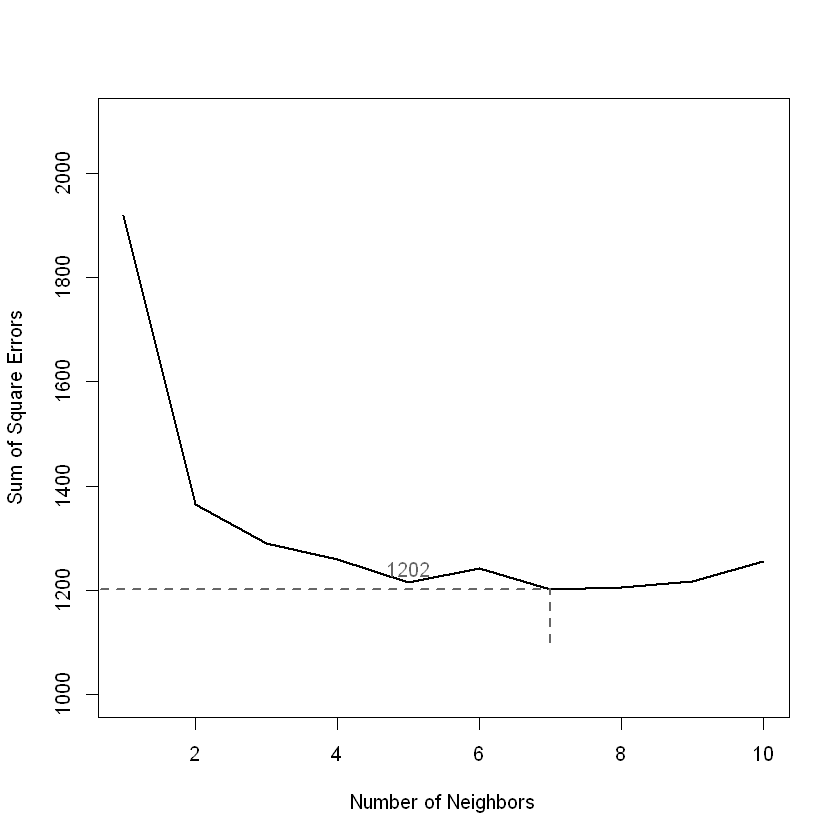

In [653]:
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(1000, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

In [654]:
kMin

[1] 7

In [655]:
estXYk5 = predXY(newSignals = onlineSummary[ , 6:max_col], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = kMin)

calcError(estXYk5, actualXY)
print(calcError(estXYk5, actualXY))

             posX      posY
length  1.4285714  4.714286
        1.0000000 11.857143
        1.0000000 11.428571
        1.1428571  9.428571
        0.4285714 10.285714
        1.1428571 11.571429
        0.8571429 11.428571
        0.7142857  2.428571
        1.7142857  7.857143
        1.2857143  9.428571
        1.0000000  5.428571
        1.0000000  3.142857
        1.1428571  1.571429
        1.8571429  7.428571
        8.7142857  7.571429
       10.8571429  4.857143
       11.1428571  3.428571
       10.8571429  5.000000
       12.0000000  5.571429
       11.7142857  6.857143
       11.8571429  4.714286
       12.2857143  3.857143
       10.1428571  7.285714
       10.8571429  7.142857
       12.2857143  4.857143
       16.2857143  7.571429
       19.7142857  7.428571
        1.1428571  7.142857
        1.4285714  8.428571
       23.7142857  4.857143
       23.4285714  3.285714
       20.8571429  7.000000
       23.2857143  5.714286
       20.4285714  6.714286
       23.1428571  6

[1] 221.4444

             posX      posY
length  1.4285714  4.714286
        1.0000000 11.857143
        1.0000000 11.428571
        1.1428571  9.428571
        0.4285714 10.285714
        1.1428571 11.571429
        0.8571429 11.428571
        0.7142857  2.428571
        1.7142857  7.857143
        1.2857143  9.428571
        1.0000000  5.428571
        1.0000000  3.142857
        1.1428571  1.571429
        1.8571429  7.428571
        8.7142857  7.571429
       10.8571429  4.857143
       11.1428571  3.428571
       10.8571429  5.000000
       12.0000000  5.571429
       11.7142857  6.857143
       11.8571429  4.714286
       12.2857143  3.857143
       10.1428571  7.285714
       10.8571429  7.142857
       12.2857143  4.857143
       16.2857143  7.571429
       19.7142857  7.428571
        1.1428571  7.142857
        1.4285714  8.428571
       23.7142857  4.857143
       23.4285714  3.285714
       20.8571429  7.000000
       23.2857143  5.714286
       20.4285714  6.714286
       23.1428571  6

In [656]:
offlineSummary_copy=offlineSummary

In [657]:
subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
            "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
            "00:14:bf:b1:97:81")

offlineSummary = subset(offlineSummary_copy, mac !=subMacs[2])
mac_number = length(unique(offlineSummary$mac))

In [658]:
######  C0  ###########

In [659]:
# tally signal strength

macs = unique(offlineSummary$mac)
online = readData("online.final.trace.txt", subMacs = macs)

online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

tabonlineXYA = table(online$posXY, online$angle)
#tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  print(avgSS)
                  y = matrix(avgSS, nrow = 1, ncol = mac_number,
                             dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc) 

[1] 60

00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
        -52.22727         -62.94898         -61.81395         -40.06897 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
        -63.04301         -55.23333 
00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
        -55.27523         -73.96190         -72.70103         -47.81308 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
        -69.45455         -46.88000 
00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
        -51.70909         -70.08247         -70.09890         -54.08824 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
        -69.13158         -53.88660 
00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
        -49.50000         -64.25806         -72.59770         -45.65289 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
        -60.79747         -49.58000 
00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
        -53.26364         -66.96000         -66

In [660]:
onlineSummary

,posXY,posX,posY,orientation,angle,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0.05,0-0.05,0.00,0.05,130.5,135,-52.22727,-62.94898,-61.81395,-40.06897,-63.04301,-55.23333
0.15-9.42,0.15-9.42,0.15,9.42,112.3,90,-55.27523,-73.96190,-72.70103,-47.81308,-69.45455,-46.88000
0.31-11.09,0.31-11.09,0.31,11.09,230.1,225,-51.70909,-70.08247,-70.09890,-54.08824,-69.13158,-53.88660
0.47-8.2,0.47-8.2,0.47,8.20,5.8,0,-49.50000,-64.25806,-72.59770,-45.65289,-60.79747,-49.58000
0.78-10.94,0.78-10.94,0.78,10.94,348.3,0,-53.26364,-66.96000,-66.80952,-48.41379,-65.00000,-54.84694
0.93-11.69,0.93-11.69,0.93,11.69,158.3,180,-57.96364,-70.44340,-70.58025,-43.66346,-65.59302,-47.27083
1.08-12.19,1.08-12.19,1.08,12.19,229.1,225,-54.82727,-69.20192,-67.92553,-52.00820,-71.58696,-51.66667
1.24-3.93,1.24-3.93,1.24,3.93,261.5,270,-56.47273,-69.62745,-59.76136,-38.91753,-71.66667,-53.23333
1.39-6.61,1.39-6.61,1.39,6.61,114.1,135,-51.28182,-62.23913,-64.56627,-48.92381,-60.79798,-50.49057
1.52-9.32,1.52-9.32,1.52,9.32,7.0,0,-50.36697,-63.35922,-67.48913,-50.04167,-65.10345,-49.38542


In [661]:
max_col=ncol(onlineSummary)
max_col

[1] 11

In [662]:
estXYk3 = predXY(newSignals = onlineSummary[ , 6:max_col], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

# nearest neighbor
estXYk1 = predXY(newSignals = onlineSummary[ , 6:max_col], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)

calcError = 
  function(estXY, actualXY) 
    sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)

[1] 659.4003 306.7025

In [663]:
# up to 20 neighbors, 11 folds
# this one can run for a while (5-10 mins)
# this cell and the next are the same, but the angles change slightly!!
offline_copy=offline

offline = offline_copy[ offline_copy$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS1(offline, keepVars = keepVars, 
                            sampleAngle = TRUE)

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:max_col], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 1, k = 3)

# actualFold = onlineFold[ , c("posX", "posY")]
# calcError(estFold, actualFold)

In [665]:
onlineCVSummary

,posXY,posX,posY,orientation,angle,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,270.1,270,-54.63636,-67.93137,-68.06098,-38.55670,-64.31395,-57.94681
0-1,0-1,0,1,269.9,270,-55.66055,-67.44762,-68.94382,-38.60194,-66.02128,-55.13592
0-10,0-10,0,10,45.1,45,-53.10909,-67.14286,-66.75556,-53.91589,-65.91954,-48.08333
0-11,0-11,0,11,90.0,90,-56.75455,-71.12371,-69.08696,-50.83673,-67.04494,-55.44118
0-12,0-12,0,12,0.2,0,-56.60000,-67.56667,-71.97959,-38.40404,-68.48235,-54.56122
0-13,0-13,0,13,44.9,45,-59.08182,-71.64151,-75.48421,-46.40777,-70.18478,-53.75248
0-2,0-2,0,2,270.1,270,-57.92727,-64.29592,-60.05618,-42.10417,-64.47059,-53.92157
0-3,0-3,0,3,179.6,180,-53.39091,-59.60227,-54.58065,-45.53398,-63.48913,-56.93407
0-4,0-4,0,4,134.8,135,-49.37273,-67.49138,-60.66000,-36.17045,-59.71579,-53.35955
0-7,0-7,0,7,45.4,45,-60.15596,-56.83333,-62.20779,-47.78302,-48.93103,-59.79167


In [666]:
K = 10
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:max_col],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 1, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

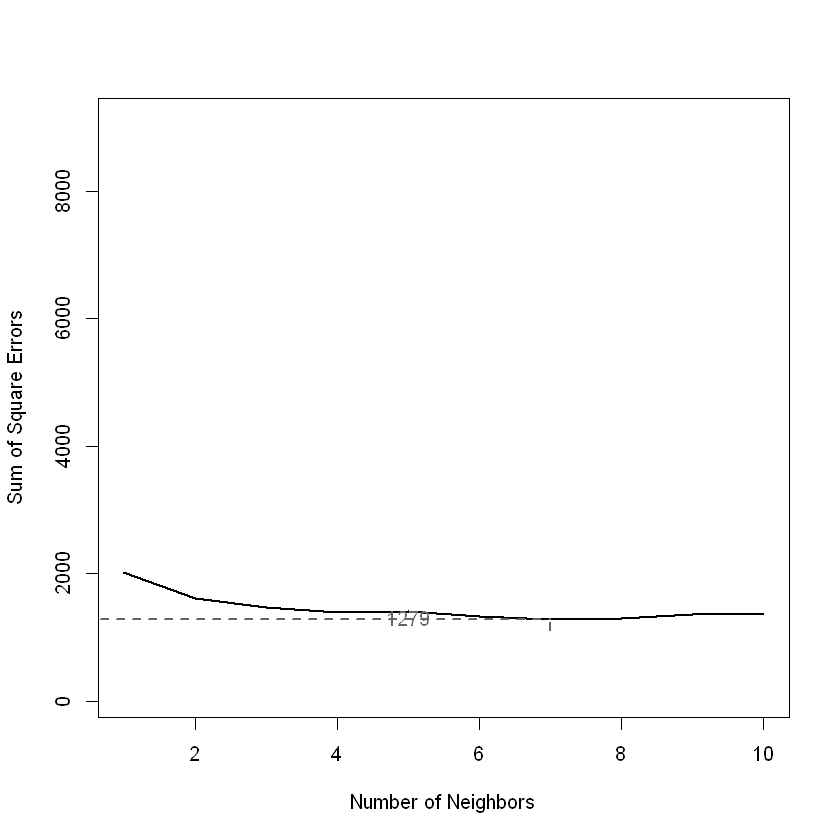

In [667]:
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(100, 9100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

In [668]:
estXYk5 = predXY(newSignals = onlineSummary[ , 6:max_col], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = kMin)

calcError(estXYk5, actualXY)
print(calcError(estXYk5, actualXY))

[1] 273.6803

[1] 273.6803


In [670]:
subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
            "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
            "00:14:bf:b1:97:81")

offlineSummary = subset(offlineSummary_copy, mac !=subMacs[1])
mac_number = length(unique(offlineSummary$mac))

In [671]:
offlineSummary

,time,posX,posY,orientation,mac,signal,rawTime,angle,posXY,medSignal,avgSignal,num,sdSignal,iqrSignal
7,2006-02-11 00:31:58,0,0,0.0,00:0f:a3:39:dd:cd,-75,1.139643e+12,0,0-0,-67.0,-68.12613,111,3.159739,4.50
24512,2006-02-11 01:03:44,0,1,0.7,00:0f:a3:39:dd:cd,-73,1.139645e+12,0,0-1,-70.0,-70.33636,110,2.420392,3.00
221777,2006-02-11 04:46:02,0,10,0.9,00:0f:a3:39:dd:cd,-69,1.139658e+12,0,0-10,-67.0,-69.24324,111,4.407053,6.50
229191,2006-02-11 04:54:05,0,11,0.4,00:0f:a3:39:dd:cd,-72,1.139659e+12,0,0-11,-73.0,-74.30631,111,5.396620,7.00
236493,2006-02-11 05:02:32,0,12,0.2,00:0f:a3:39:dd:cd,-72,1.139659e+12,0,0-12,-70.0,-69.57895,114,2.372015,3.00
243546,2006-02-11 05:14:12,0,13,0.1,00:0f:a3:39:dd:cd,-69,1.139660e+12,0,0-13,-74.0,-73.58716,109,3.493939,4.00
49629,2006-02-11 01:26:28,0,2,0.3,00:0f:a3:39:dd:cd,-71,1.139646e+12,0,0-2,-68.0,-68.58929,112,2.976041,4.00
73868,2006-02-11 01:47:06,0,3,0.2,00:0f:a3:39:dd:cd,-72,1.139648e+12,0,0-3,-69.0,-69.09649,114,1.982085,2.00
99015,2006-02-11 02:05:57,0,4,0.5,00:0f:a3:39:dd:cd,-66,1.139649e+12,0,0-4,-68.0,-68.94643,112,3.972517,6.00
199298,2006-02-11 04:22:44,0,7,0.3,00:0f:a3:39:dd:cd,-66,1.139657e+12,0,0-7,-72.0,-71.43636,110,3.428235,5.00


In [672]:
# tally signal strength

macs = unique(offlineSummary$mac)
online = readData("online.final.trace.txt", subMacs = macs)

online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

tabonlineXYA = table(online$posXY, online$angle)
#tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  print(avgSS)
                  y = matrix(avgSS, nrow = 1, ncol = mac_number,
                             dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc) 

[1] 60

00:0f:a3:39:dd:cd 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
        -63.20721         -62.94898         -61.81395         -40.06897 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
        -63.04301         -55.23333 
00:0f:a3:39:dd:cd 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
        -66.11712         -73.96190         -72.70103         -47.81308 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
        -69.45455         -46.88000 
00:0f:a3:39:dd:cd 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
        -67.05405         -70.08247         -70.09890         -54.08824 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
        -69.13158         -53.88660 
00:0f:a3:39:dd:cd 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
        -74.15315         -64.25806         -72.59770         -45.65289 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
        -60.79747         -49.58000 
00:0f:a3:39:dd:cd 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
        -71.40367         -66.96000         -66

In [673]:
onlineSummary

,posXY,posX,posY,orientation,angle,00:0f:a3:39:dd:cd,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0.05,0-0.05,0.00,0.05,130.5,135,-63.20721,-62.94898,-61.81395,-40.06897,-63.04301,-55.23333
0.15-9.42,0.15-9.42,0.15,9.42,112.3,90,-66.11712,-73.96190,-72.70103,-47.81308,-69.45455,-46.88000
0.31-11.09,0.31-11.09,0.31,11.09,230.1,225,-67.05405,-70.08247,-70.09890,-54.08824,-69.13158,-53.88660
0.47-8.2,0.47-8.2,0.47,8.20,5.8,0,-74.15315,-64.25806,-72.59770,-45.65289,-60.79747,-49.58000
0.78-10.94,0.78-10.94,0.78,10.94,348.3,0,-71.40367,-66.96000,-66.80952,-48.41379,-65.00000,-54.84694
0.93-11.69,0.93-11.69,0.93,11.69,158.3,180,-69.99074,-70.44340,-70.58025,-43.66346,-65.59302,-47.27083
1.08-12.19,1.08-12.19,1.08,12.19,229.1,225,-73.43750,-69.20192,-67.92553,-52.00820,-71.58696,-51.66667
1.24-3.93,1.24-3.93,1.24,3.93,261.5,270,-71.11009,-69.62745,-59.76136,-38.91753,-71.66667,-53.23333
1.39-6.61,1.39-6.61,1.39,6.61,114.1,135,-59.75676,-62.23913,-64.56627,-48.92381,-60.79798,-50.49057
1.52-9.32,1.52-9.32,1.52,9.32,7.0,0,-65.38318,-63.35922,-67.48913,-50.04167,-65.10345,-49.38542


In [674]:
estXYk3 = predXY(newSignals = onlineSummary[ , 6:max_col], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

# nearest neighbor
estXYk1 = predXY(newSignals = onlineSummary[ , 6:max_col], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)

calcError = 
  function(estXY, actualXY) 
    sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)

[1] 411.6403 270.4581

In [675]:
# up to 20 neighbors, 11 folds
# this one can run for a while (5-10 mins)
# this cell and the next are the same, but the angles change slightly!!

offline = offline_copy[ offline_copy$mac != "00:0f:a3:39:e1:c0", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS1(offline, keepVars = keepVars, 
                            sampleAngle = TRUE)

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:max_col], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 1, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

[1] 134.7778

In [676]:
offline_copy

,time,posX,posY,orientation,mac,signal,rawTime,angle,posXY
1,2006-02-11 00:31:58,0,0,0,00:14:bf:b1:97:8a,-38,1.139643e+12,0,0-0
2,2006-02-11 00:31:58,0,0,0,00:14:bf:b1:97:90,-56,1.139643e+12,0,0-0
3,2006-02-11 00:31:58,0,0,0,00:0f:a3:39:e1:c0,-53,1.139643e+12,0,0-0
4,2006-02-11 00:31:58,0,0,0,00:14:bf:b1:97:8d,-65,1.139643e+12,0,0-0
5,2006-02-11 00:31:58,0,0,0,00:14:bf:b1:97:81,-65,1.139643e+12,0,0-0
6,2006-02-11 00:31:58,0,0,0,00:14:bf:3b:c7:c6,-66,1.139643e+12,0,0-0
7,2006-02-11 00:31:58,0,0,0,00:0f:a3:39:dd:cd,-75,1.139643e+12,0,0-0
12,2006-02-11 00:31:58,0,0,0,00:14:bf:b1:97:8a,-38,1.139643e+12,0,0-0
13,2006-02-11 00:31:58,0,0,0,00:0f:a3:39:e1:c0,-54,1.139643e+12,0,0-0
14,2006-02-11 00:31:58,0,0,0,00:14:bf:b1:97:90,-56,1.139643e+12,0,0-0


In [677]:
K = 10
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:max_col],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 1, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

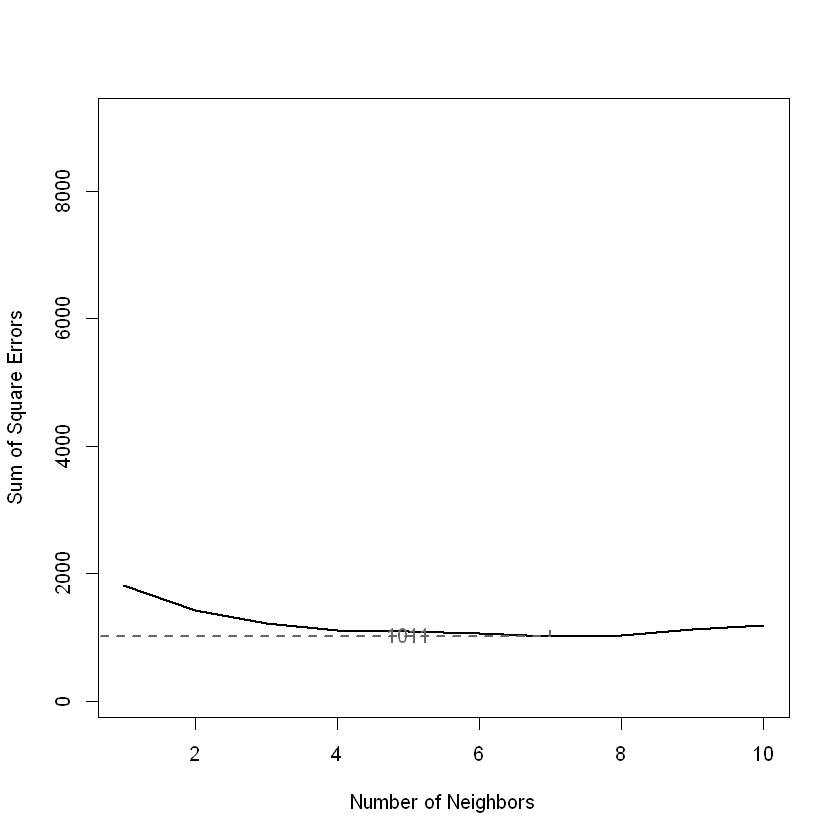

In [678]:
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(100, 9100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

In [679]:
estXYk5 = predXY(newSignals = onlineSummary[ , 6:max_col], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = kMin)

calcError(estXYk5, actualXY)
print(calcError(estXYk5, actualXY))

[1] 258.075

[1] 258.075
